# \begin{equation*} \frac{D \sigma}{D t} = \dot\sigma_{\theta} = \frac{\partial \sigma_{\theta}}{\partial \theta} \dot\theta + \frac{\partial \sigma_{\theta}}{\partial S} \dot S \end{equation*}
## **ECCO**

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.5.121:46353")
client

Client Scheduler: tcp://10.32.5.121:46353 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 29 Cores: 58 Memory: 333.50 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba
#from fastjmd95 import rho, drhods, drhodt

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
xr.set_options(display_style='text')

In [4]:
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/coords_wg.zarr')) #didn't upload wg region
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tns.zarr'))
#ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg.zarr'))
ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_slt_wg_new.zarr'))
ds_tmp = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_tmp_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/ds_vel.zarr'))
ds = xr.merge([ds_tns, ds_slt, ds_tmp, ds_vel])
ds

<xarray.Dataset>
Dimensions:                  (i: 95, i_g: 96, j: 50, j_g: 51, k: 50, k_l: 50, time: 288, time_snp: 287)
Coordinates:
  * i                        (i) int64 333 334 335 336 337 ... 63 64 65 66 67
  * j                        (j) int64 30 31 32 33 34 35 ... 74 75 76 77 78 79
  * k                        (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
  * time_snp                 (time_snp) datetime64[ns] 1992-02-01 ... 2015-12-01
  * k_l                      (k_l) int64 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
Dimensions without coordinates: i_g, j_g
Data variables:
    SALT                     (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    SALT_snp                 (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    THETA                    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    THETA_snp                (time_snp, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    dt                       (time) float32 dask.array<chunksize=(288,), meta=np.ndarray>
    G_adv                    (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_adv_conv               (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_diff                   (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_forc                   (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_tot                    (time, k, j, i) float32 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    conv_horiz_adv_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_TH     (k, time, j, i) float32 dask.array<chunksize=(50, 1, 50, 95), meta=np.ndarray>
    sw_flux_conv_TH          (time, j, i, k) float32 dask.array<chunksize=(1, 50, 95, 50), meta=np.ndarray>
    total_tendency_TH_truth  (time, k, j, i) float32 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    UVEL                     (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    UVELSTAR                 (time, k, j, i_g) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    VVEL                     (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    VVELSTAR                 (time, k, j_g, i) float32 dask.array<chunksize=(1, 50, 51, 67), meta=np.ndarray>
    WVEL                     (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>
    WVELSTAR                 (time, k_l, j, i) float32 dask.array<chunksize=(1, 50, 50, 67), meta=np.ndarray>

In [5]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row
j_g_upper = 81
i_g_right = 119
i_g_left = 22

In [6]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(lower_lat, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(left_lon, i_g_right))

In [7]:
#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

In [8]:
pref = 2000

# <font color='Green'> \begin{equation*} Temperature \end{equation*} </font>

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial \theta}\end{equation*} </font>

In [9]:
drhodt = xr.apply_ufunc(jmd95numba.drhodt, ds.SALT, ds.THETA, pref,
                        output_dtypes=[ds.SALT.dtype],
                        dask='parallelized').reset_coords(drop=True).load()

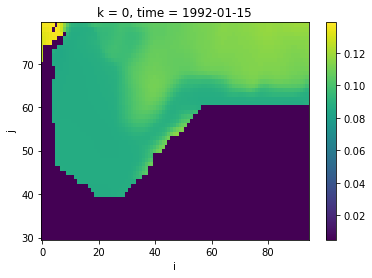

In [10]:
(-drhodt[0,0]).drop('i').plot()

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial \theta} \dot \theta \end{equation*} </font>

In [11]:
ds_sig_theta = drhodt * ds_tmp

In [12]:
ds_sig_theta

<xarray.Dataset>
Dimensions:                  (i: 95, j: 50, k: 50, time: 288)
Coordinates:
  * j                        (j) int64 30 31 32 33 34 35 ... 74 75 76 77 78 79
  * i                        (i) int64 333 334 335 336 337 ... 63 64 65 66 67
  * k                        (k) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
  * time                     (time) datetime64[ns] 1992-01-15 ... 2015-12-14
Data variables:
    conv_horiz_adv_flux_TH   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    surface_flux_conv_TH     (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    sw_flux_conv_TH          (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>
    total_tendency_TH_truth  (time, k, j, i) float64 dask.array<chunksize=(1, 50, 50, 95), meta=np.ndarray>

In [13]:
rhs_theta = (ds_sig_theta.conv_horiz_adv_flux_TH + 
              ds_sig_theta.conv_horiz_diff_flux_TH + 
              ds_sig_theta.conv_vert_adv_flux_TH +
              ds_sig_theta.conv_vert_diff_flux_TH + 
              ds_sig_theta.surface_flux_conv_TH + 
              ds_sig_theta.sw_flux_conv_TH).load()

lhs_theta = ds_sig_theta.total_tendency_TH_truth.load()

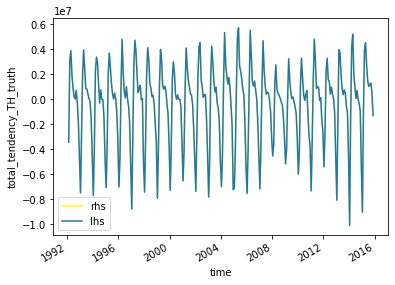

In [14]:
#checking equality
rhs_theta[1:-1].sum(['i', 'j', 'k']).plot(label='rhs', color='yellow')
lhs_theta[1:-1].sum(['i', 'j', 'k']).plot(label='lhs')
plt.legend();

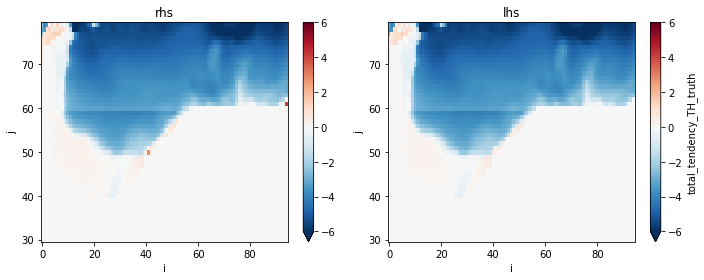

In [15]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
rhs_theta[1:-1].mean(dim=['time', 'k']).drop('i').plot(ax=ax0, vmax=6)
ax0.set_title('rhs')
lhs_theta[1:-1].mean(dim=['time', 'k']).drop('i').plot(ax=ax1, vmax=6)
ax1.set_title('lhs')
plt.tight_layout();

In [16]:
rhs_vars = [dvar for dvar in ds_sig_theta.data_vars
            if dvar != 'total_tendency_TH_truth']
total_tendency_check = sum([ds_sig_theta[dvar] for dvar in rhs_vars])
total_tendency_check

<xarray.DataArray (time: 288, k: 50, j: 50, i: 95)>
dask.array<add, shape=(288, 50, 50, 95), dtype=float64, chunksize=(1, 50, 50, 95), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

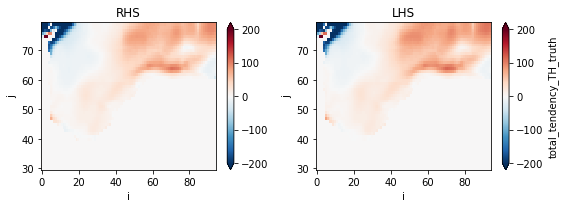

In [17]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[200, 0].drop('i').plot(ax=ax0, robust=True, vmax=200)
ax0.set_title('RHS')

ds_sig_theta.total_tendency_TH_truth[200, 0].drop('i').plot(ax=ax1, robust=True, vmax=200)
ax1.set_title('LHS')
plt.tight_layout();

# <font color='Green'> \begin{equation*} Salinity \end{equation*} </font>

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial S} \end{equation*} </font>

In [18]:
drhods = xr.apply_ufunc(jmd95numba.drhods, ds.SALT, ds.THETA, 2000,
                        output_dtypes=[ds.SALT.dtype],
                        dask='parallelized').reset_coords(drop=True).load()

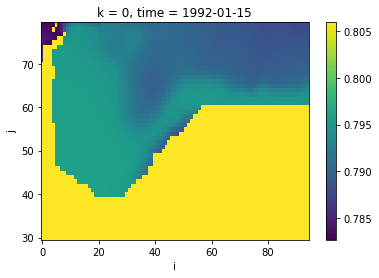

In [20]:
drhods[0,0].drop('i').plot()

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial S} \dot S \end{equation*} </font>

In [23]:
ds_sig_salt = drhods * ds_slt

In [24]:
ds_sig_salt

<xarray.Dataset>
Dimensions:     (i: 95, j: 50, k: 50, time: 288)
Coordinates:
  * i           (i) int64 333 334 335 336 337 338 339 ... 61 62 63 64 65 66 67
  * j           (j) int64 30 31 32 33 34 35 36 37 38 ... 72 73 74 75 76 77 78 79
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Data variables:
    G_adv       (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_adv_conv  (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_diff      (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_forc      (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>
    G_tot       (time, k, j, i) float64 dask.array<chunksize=(48, 50, 50, 67), meta=np.ndarray>

In [25]:
rhs_salt = (ds_sig_salt.G_adv + 
             ds_sig_salt.G_adv_conv + 
             ds_sig_salt.G_diff +
             ds_sig_salt.G_forc).load()

lhs_salt = ds_sig_salt.G_tot.load()

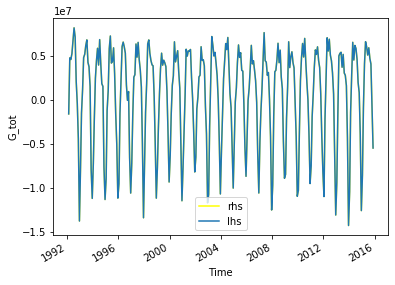

In [26]:
#checking equality
rhs_salt[1:-1].sum(['i', 'j', 'k']).plot(label='rhs', color='yellow')
lhs_salt[1:-1].sum(['i', 'j', 'k']).plot(label='lhs')
plt.legend();

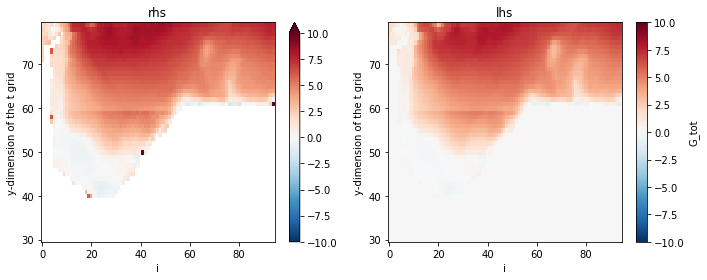

In [28]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
rhs_salt[1:-1].mean(dim=['time', 'k']).drop('i').plot(ax=ax0, vmax=10)
ax0.set_title('rhs')
lhs_salt[1:-1].mean(dim=['time', 'k']).drop('i').plot(ax=ax1, vmax=10)
ax1.set_title('lhs')
plt.tight_layout();

In [31]:
rhs_vars_salt = [dvar for dvar in ds_sig_salt.data_vars
            if dvar != 'G_tot']
total_tendency_check_salt = sum([ds_sig_salt[dvar] for dvar in rhs_vars_salt])
total_tendency_check_salt

<xarray.DataArray (time: 288, k: 50, j: 50, i: 95)>
dask.array<add, shape=(288, 50, 50, 95), dtype=float64, chunksize=(48, 50, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 333 334 335 336 337 338 339 340 ... 61 62 63 64 65 66 67
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14

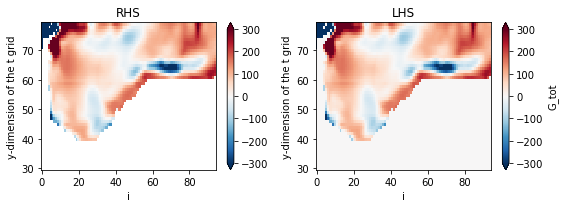

In [32]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check_salt[200, 0].drop('i').plot(ax=ax0, robust=True, vmax=300)
ax0.set_title('RHS')

ds_sig_salt.G_tot[200, 0].drop('i').plot(ax=ax1, robust=True, vmax=300)
ax1.set_title('LHS')
plt.tight_layout();

## Saving Data

In [33]:
drhodts = xr.merge([drhodt.rename('drhodt'), drhods.rename('drhods')])

In [34]:
import json
with open('/home/jovyan/WMT/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [111]:
#saving theta component of drho/dtime
gcsmap_sig_theta = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_sig_theta.zarr')
ds_sig_theta.to_zarr(gcsmap_sig_theta, mode='w')

In [35]:
#saving salt component of drho/dtime
gcsmap_sig_salt = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/ds_sig_salt_new.zarr')
ds_sig_salt.to_zarr(gcsmap_sig_salt, mode='w')

In [ ]:
#saving rhodt and drhods
gcsmap_drhodts = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/drhodts_new.zarr')
drhodts.to_zarr(gcsmap_drhodts, mode='w')